In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [22]:
# Imports here
import json
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import argparse
from os.path import isdir

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/master/torchvision/transforms.html#)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. This converts the values of each color channel to be between -1 and 1 instead of 0 and 1.

In [5]:
data_dir = '/content/drive/MyDrive/ImageClassifier/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


In [23]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Using the image datasets and the transforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [24]:
import json

with open('/content/drive/MyDrive/ImageClassifier/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [25]:
model = models.vgg16(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Define a new, untrained feed-forward network as a classifier
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4096)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.5)),
    ('fc2', nn.Linear(4096, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
epochs = 5
print_every = 40
steps=0

for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            model.eval()
            with torch.no_grad():
                valid_loss, accuracy = validate_model(model, valid_loader, criterion, device)

            print(f"Epoch: {epoch + 1}/{epochs} | "
                  f"Training Loss: {running_loss/print_every:.4f} | "
                  f"Validation Loss: {valid_loss/len(valid_loader):.4f} | "
                  f"Validation Accuracy: {accuracy/len(valid_loader):.4f}")

            running_loss = 0
            model.train()

print("Training complete!")

Epoch: 1/5 | Training Loss: 0.0471 | Validation Loss: 1.0998 | Validation Accuracy: 0.7107
Epoch: 1/5 | Training Loss: 0.0406 | Validation Loss: 1.0882 | Validation Accuracy: 0.7177
Epoch: 1/5 | Training Loss: 0.0406 | Validation Loss: 1.0845 | Validation Accuracy: 0.7189
Epoch: 1/5 | Training Loss: 0.0403 | Validation Loss: 1.0869 | Validation Accuracy: 0.7153
Epoch: 1/5 | Training Loss: 0.0500 | Validation Loss: 1.0680 | Validation Accuracy: 0.7009
Epoch: 1/5 | Training Loss: 0.0317 | Validation Loss: 1.0517 | Validation Accuracy: 0.7069
Epoch: 1/5 | Training Loss: 0.0417 | Validation Loss: 1.0379 | Validation Accuracy: 0.7129
Epoch: 1/5 | Training Loss: 0.0511 | Validation Loss: 1.0085 | Validation Accuracy: 0.7210
Epoch: 1/5 | Training Loss: 0.0460 | Validation Loss: 0.9834 | Validation Accuracy: 0.7328
Epoch: 1/5 | Training Loss: 0.0462 | Validation Loss: 0.9584 | Validation Accuracy: 0.7436
Epoch: 1/5 | Training Loss: 0.0584 | Validation Loss: 0.9442 | Validation Accuracy: 0.7553

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [30]:
test_loss, accuracy = validate_model(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss/len(test_loader):.4f} | "
      f"Test Accuracy: {accuracy/len(test_loader):.4f}")

Test Loss: 0.8937 | Test Accuracy: 0.7759


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [31]:
def save_checkpoint(model, save_dir, train_data, optimizer, epochs):
    if type(save_dir) == type(None):
        print("Model checkpoint directory not specified, model will not be saved.")
    else:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # Save class to index mapping
        model.class_to_idx = train_data.class_to_idx

        # Create checkpoint dictionary
        checkpoint = {
            'architecture': model.name,
            'classifier': model.classifier,
            'class_to_idx': model.class_to_idx,
            'state_dict': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'epochs': epochs
        }

        # Save the checkpoint to a file
        checkpoint_path = os.path.join(save_dir, 'checkpoint.pth')
        torch.save(checkpoint, checkpoint_path)
        print("Model checkpoint saved successfully at:", checkpoint_path)


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [33]:
def load_checkpoint(filepath):
    # Load the checkpoint
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))

    # Check if the model architecture is available in torchvision models
    if checkpoint['architecture'] in models.__dict__:
        model = models.__dict__[checkpoint['architecture']](pretrained=False)
    else:
        print(f"Error: Architecture {checkpoint['architecture']} not recognized.")
        return None

    # Replace the classifier with the one saved in the checkpoint
    model.classifier = checkpoint['classifier']

    # Load the state_dict into the model
    model.load_state_dict(checkpoint['state_dict'])

    # Load the class_to_idx mapping
    model.class_to_idx = checkpoint['class_to_idx']

    return model




# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network.

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [45]:

from PIL import Image
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image_path)

    # Resize
    img = img.resize((256, 256))

    # Center crop
    left_margin = (img.width - 224) / 2
    bottom_margin = (img.height - 224) / 2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin, top_margin))

    # Normalize
    img = np.array(img) / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean) / std

    # Transpose dimensions
    img = img.transpose((2, 0, 1))

    return img


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

<Axes: >

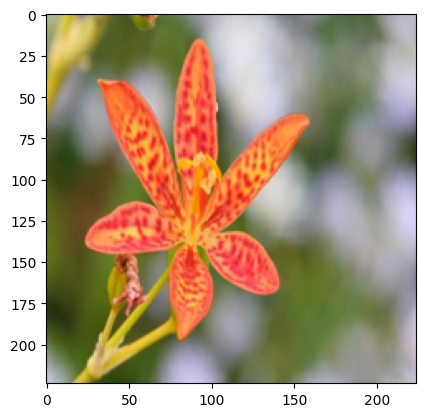

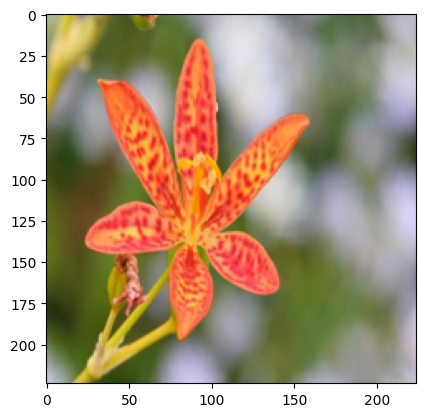

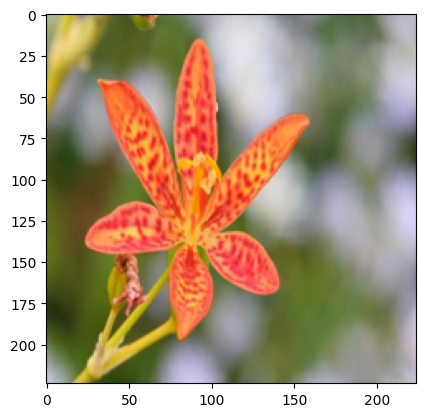

In [53]:
def imshow(image, ax=None, title=None):
    #img for tensor
    if ax is None:
        fig, ax = plt.subplots()


    image = image.transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean


    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

imshow(process_image("/content/drive/MyDrive/ImageClassifier/flowers/test/102/image_08015.jpg"))
imshow(process_image("/content/drive/MyDrive/ImageClassifier/flowers/test/102/image_08042.jpg"))
imshow(process_image("/content/drive/MyDrive/ImageClassifier/flowers/test/102/image_08004.jpg"))


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [81]:
def predict(image_path, model, class_to_idx, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Process the image
    img = process_image(image_path)

    # Convert to PyTorch tensor
    img_tensor = torch.tensor(img, dtype=torch.float32)

    # Add batch dimension
    img_tensor = img_tensor.unsqueeze(0)

    # Move to the device
    img_tensor = img_tensor.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make the prediction
    with torch.no_grad():
        output = model(img_tensor)

    # Calculate probabilities and indices
    probs, indices = torch.topk(torch.softmax(output, dim=1), topk)

    # Move tensors to CPU before converting to NumPy
    probs = probs.cpu().numpy()

    # Convert indices to classes using the provided class_to_idx dictionary
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    classes = [idx_to_class[idx.item()] for idx in indices[0]]

    return probs[0], classes



## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

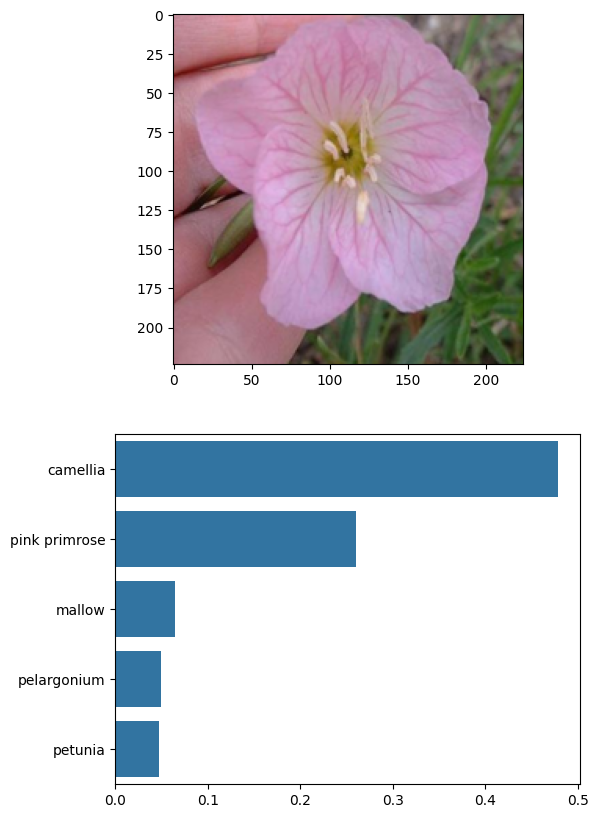

In [87]:
import seaborn as sns

image_path = "/content/drive/MyDrive/ImageClassifier/flowers/test/1/image_06754.jpg"

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(image_path))[0]

# Attempt to get category name from cat_to_name
title_ = cat_to_name.get(file_name, f"Unknown Flower ({file_name})")

plt.figure(figsize=(6, 10))
ax = plt.subplot(2, 1, 1)

# Plot flower
img = process_image(image_path)
imshow(img, ax, title=title_);

# Make prediction
sanity_probs, sanity_classes = predict(image_path, model, train_data.class_to_idx, topk=5)

# Map class indices to flower names
class_names = [cat_to_name[class_idx] for class_idx in sanity_classes]

plt.subplot(2, 1, 2)
sns.barplot(x=sanity_probs, y=class_names, color=sns.color_palette()[0])
plt.show()



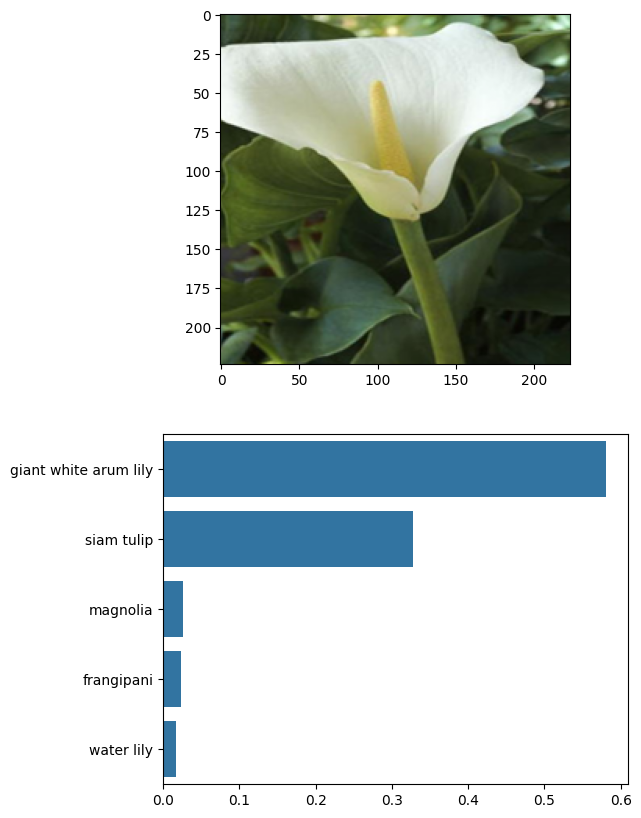

In [88]:


image_path = "/content/drive/MyDrive/ImageClassifier/flowers/test/20/image_04910.jpg"

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(image_path))[0]

# Attempt to get category name from cat_to_name
title_ = cat_to_name.get(file_name, f"Unknown Flower ({file_name})")

plt.figure(figsize=(6, 10))
ax = plt.subplot(2, 1, 1)

# Plot flower
img = process_image(image_path)
imshow(img, ax, title=title_);

# Make prediction
sanity_probs, sanity_classes = predict(image_path, model, train_data.class_to_idx, topk=5)

# Map class indices to flower names
class_names = [cat_to_name[class_idx] for class_idx in sanity_classes]

plt.subplot(2, 1, 2)
sns.barplot(x=sanity_probs, y=class_names, color=sns.color_palette()[0])
plt.show()
